# 支持向量机

思想：最大化间隔

**hard-margin SVM**

模型：$h(x)=sign(w^Tx+b)$

优化目标：$min\frac{1}{2}w^Tw\\
s.t.　y_i(w^Tx_i+b)\geqslant 1,　i=1,2,...,m$

利用拉格朗日乘子法，转换成无约束优化问题。

原形式：$min_{w,b}max_{\lambda}L(w,b,\lambda)=\frac{1}{2}w^Tw+\sum_{i=1}^{m}\lambda_i(1-y_i(w^Tx_i+b))\\
s.t.　\lambda_i \geqslant 0$

对偶形式：$max_{\lambda}min_{w,b}L(w,b,\lambda)=max_{\lambda}\sum_{i=1}^{m}\lambda_i-\frac{1}{2}\sum_{i=1}^{m}\sum_{j=1}^{m}\lambda_i\lambda_jy_iy_jx_i^Tx_j\\
s.t.　\lambda_i \geqslant 0　and　\sum_{i=1}^{m}\lambda_iy_i=0$

原问题为凸优化问题，满足KKT条件$\Leftrightarrow$强对偶关系：

$1. \bigtriangledown_xL(w,b,\lambda)=0\\
2. \lambda_i \geqslant 0\\
3. 1-y_i(w^Tx_i+b)\leqslant 0\\
4. \lambda_i(1-y_i(w^Tx_i+b))=0$

最后利用SMO算法求解参数。

**soft-margin SVM**

$min_{w,b}\frac{1}{2}w^Tw+C\sum_{i=1}^{m}\xi_i\\
s.t.　\xi_i>0　and　y_i(w^Tx_i+b)\geqslant 1-\xi_i$

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
wh_data = pd.read_csv('武汉.csv', index_col='date', encoding='utf-8', engine='python')
wh_data.drop(wh_data[wh_data['质量等级']=='无'].index, inplace=True)
wh_data.head()

,AQI,质量等级,PM2.5,PM10,SO2,CO,NO2,O3_8h
date,,,,,,,,
2014-01-01,203,重度污染,153,210,70,2.0,106,55
2014-01-02,231,重度污染,181,254,89,2.4,112,26
2014-01-03,224,重度污染,174,226,63,1.7,84,55
2014-01-04,147,轻度污染,112,184,73,1.6,87,40
2014-01-05,195,中度污染,147,213,89,2.2,91,53


In [0]:
def get_grade(aqi):
    if aqi <= 100:
        return 1
    else:
        return -1

In [4]:
wh_data['GRADE'] = wh_data.AQI.apply(get_grade)
wh_data.dropna(inplace=True)
wh_data.groupby('GRADE').count().AQI

GRADE
-1     689
 1    1125
Name: AQI, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

X = wh_data.iloc[:, 2:4]
y = wh_data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

In [0]:
from sklearn.preprocessing import StandardScaler

standardscaler = StandardScaler()
standardscaler.fit(X_train)
X_train_sca = standardscaler.transform(X_train)
X_test_sca = standardscaler.transform(X_test)

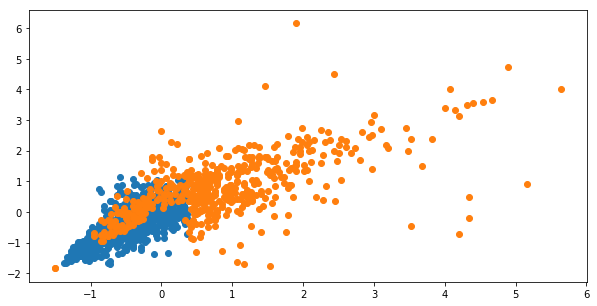

In [7]:
plt.figure(figsize=(10,5))
plt.scatter(X_train_sca[y_train==1][:,0], X_train_sca[y_train==1][:,1])
plt.scatter(X_train_sca[y_train==-1][:,0], X_train_sca[y_train==-1][:,1])
plt.show()

In [8]:
from sklearn.svm import LinearSVC

svc = LinearSVC(random_state=100)
svc.fit(X_train_sca, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=100, tol=0.0001,
          verbose=0)

In [9]:
svc.score(X_test_sca, y_test)

0.8964757709251101

**决策边界**

In [0]:
def plot_decision_boundary(model, axis):
    X0, X1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1)
    )
    X = np.c_[X0.ravel(), X1.ravel()]
    Y = model.predict(X).reshape(X0.shape)
    
    plt.contourf(X0, X1, Y)

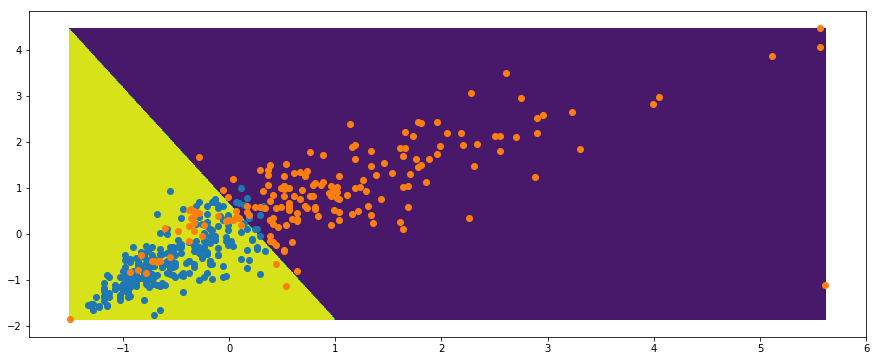

In [11]:
plt.figure(figsize=(15,6))
plot_decision_boundary(svc, axis=[np.min(X_test_sca[:,0]),np.max(X_test_sca[:,0]), np.min(X_test_sca[:,1]),np.max(X_test_sca[:,1])])
plt.scatter(X_test_sca[y_test==1][:,0], X_test_sca[y_test==1][:,1])
plt.scatter(X_test_sca[y_test==-1][:,0], X_test_sca[y_test==-1][:,1])
plt.show()

**非线性划分**

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc = SVC(kernel='rbf', random_state=100)
params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.01, 0.1, 1, 10, 100]
}
grid = GridSearchCV(svc, params, cv=3)
grid.fit(X_train_sca, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=100, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'gamma': [0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [13]:
print(grid.best_params_)
model = grid.best_estimator_
model.score(X_test_sca, y_test)

{'C': 1, 'gamma': 10}


0.9030837004405287

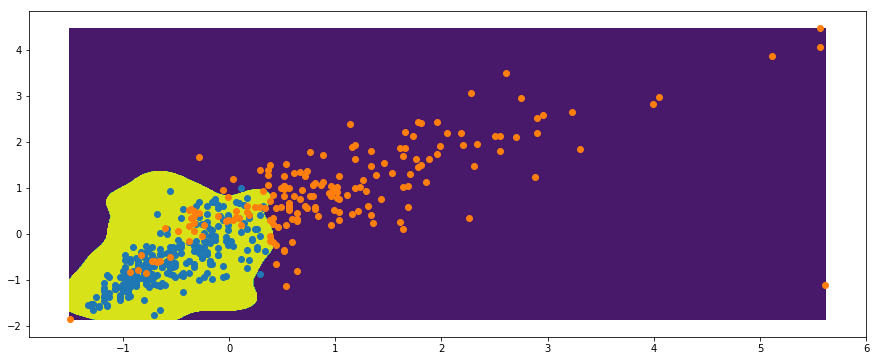

In [14]:
plt.figure(figsize=(15,6))
plot_decision_boundary(model, axis=[np.min(X_test_sca[:,0]),np.max(X_test_sca[:,0]), np.min(X_test_sca[:,1]),np.max(X_test_sca[:,1])])
plt.scatter(X_test_sca[y_test==1][:,0], X_test_sca[y_test==1][:,1])
plt.scatter(X_test_sca[y_test==-1][:,0], X_test_sca[y_test==-1][:,1])
plt.show()